# Analysis of incentivized Amazon reviews

### Leslie Huang
### May 17, 2017

Data provided by Julian McAuley, UCSD (http://jmcauley.ucsd.edu/data/amazon/)

## The data

- Amazon.com product reviews with text, rating, and summary


- 17,320,663 reviews


- Approx. ~10 GB of data


- From the following categories:

    - Health and Personal Care
    - Home and Kitchen
    - Tools and Home Improvement
    - Beauty

## The problem

Until the practice was recently banned by Amazon, sellers had an incentive to offer free or discounted products in exchange for reviews, commonly known as "incentivized reviews." Some of these reviews would include a disclaimer such as "I received this product for free in exchange for my honest, unbiased opinion." 

However, shady sellers and reviewers post fraudulent positive reviews that *cannot be easily identified* because they do not have disclaimers. This is a problem for Amazon because the integrity of reviews is important, and it's a problem for consumers, because they don't know which reviews to trust.

Thus, there is a real practical need for a tool that can identify and flag potential fraudulent reviews.

## Let's get started!

In [2]:
# Workspace setup

import math
import matplotlib
import matplotlib.pyplot as plt
import multiprocessing as mp
import nltk
from nltk.stem.snowball import SnowballStemmer
import numpy as np
from odo import odo, discover, resource
import pandas as pd
from sklearn import linear_model
from sklearn.naive_bayes import MultinomialNB
import statsmodels.formula.api as sm
from statsmodels.iolib.summary2 import summary_col
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
import warnings

warnings.simplefilter('ignore')

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12, 8)

The reviews were JSON-like objects, which I extracted into a MongoDB database.

In [3]:
# Retrieve data from MongoDB db
data = odo("mongodb://localhost/my_mongo::amazon_reviews", 
            pd.DataFrame, dshape = "var * {unixReviewTime: int32, reviewText: string, summary: string, overall: float32, asin: string, reviewerID: string}")

In [4]:
### Construct some vars

# Convert to correct datetime format
data["date"] = pd.to_datetime(data["unixReviewTime"], unit = "s")

# Create a dummy for incentivized reviews
data["hasDisclaimer"] = pd.Series(data.reviewText.str.contains(r"( in exchange for my unbiased | in exchange for my honest | free or at a discount | free or discounted | Disclosure: | Disclaimer: | disclosure: | I received this product for free | in exchange for my review )"))

## Let's explore the data

- I constructed a variable "hasDisclaimer" that is True if the review contains a phrase commonly found in disclaimers, such as:

    - "in exchange for my unbiased"
    - "in exchange for my honest"
    - "I received this product for free"
    - "in exchange for my review"
    - "Disclosure:"
    
    
- This variable probably has a lot of *false negatives*, but I wanted to minimize *false positives.*

## We'll look at a snippet of the data as well as several visualizations below.

In [5]:
data.head()

,unixReviewTime,reviewText,summary,overall,asin,reviewerID,date,hasDisclaimer
0,1369699200,i do love this moisturizer and would recommend...,bio-active anti-aging serum,5.0,0205616461,A39HTATAQ9V7YF,2013-05-28,False
1,1355443200,I received this product before the deadline.I ...,"This product is ok, I'm use Baby Kabuki in moment",3.0,0558925278,A3JM6GV9MNOF9X,2012-12-14,False
2,1404691200,I love this set. Great buy for the price. I do...,I love this set,5.0,0558925278,A1Z513UWSAAO0F,2014-07-07,False
3,1382572800,"A nice moisturizer, all natural ingredients an...",Nice Moisturizer,4.0,0733001998,A1WMRR494NWEWV,2013-10-24,False
4,1274227200,Please research the MAC Hello Kitty collection...,Fake MAC,1.0,0737104473,A3IAAVS479H7M7,2010-05-19,False


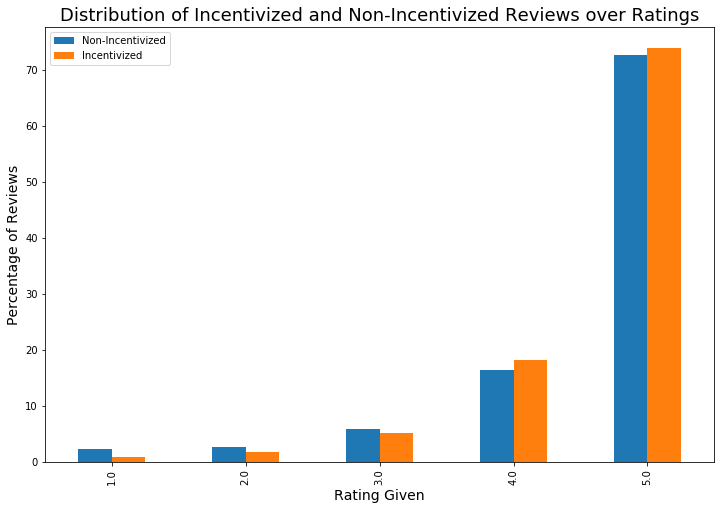

In [48]:
# Plot distributions of incentivized versus non-incentivized reviews

grouped = data.groupby(["hasDisclaimer", "overall"]).agg({"overall": "sum"})
grouped_percentages = grouped.groupby(level = 0).apply(lambda x: x / float(x.sum()) * 100)

grouped_percentages.unstack(0).plot.bar()
plt.legend(labels = ["Non-Incentivized", "Incentivized"])
plt.xlabel("Rating Given", fontsize = 14)
plt.ylabel("Percentage of Reviews", fontsize = 14)
plt.title("Distribution of Incentivized and Non-Incentivized Reviews over Ratings", fontsize = 18)

In [7]:
# Let's look at some summary statistics too

groupby_disc = data.groupby(["hasDisclaimer"])

groupby_disc["overall"].describe()

hasDisclaimer       
False          count    1.118387e+07
               mean     3.754460e+00
               std      1.434142e+00
               min      1.000000e+00
               25%      4.000000e+00
               50%      5.000000e+00
               75%      5.000000e+00
               max      5.000000e+00
True           count    1.499000e+03
               mean     4.370914e+00
               std      1.051977e+00
               min      1.000000e+00
               25%      4.000000e+00
               50%      5.000000e+00
               75%      5.000000e+00
               max      5.000000e+00
Name: overall, dtype: float64

(0, 6)

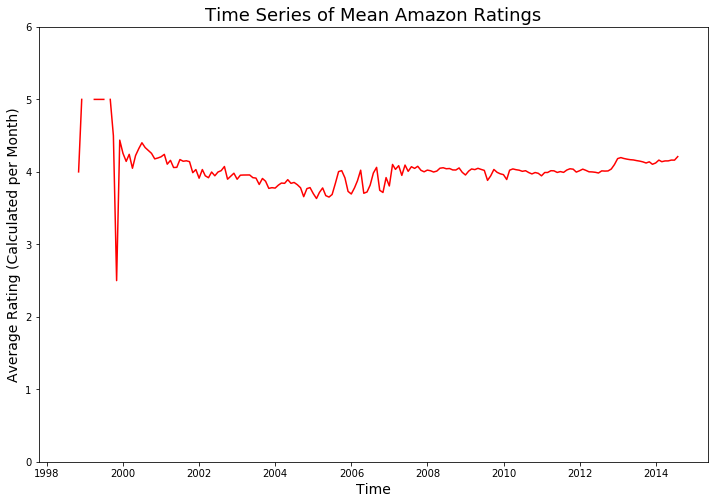

In [45]:
# Get daily mean / monthly mean of data for plotting
ts_df = data.groupby("date").agg({"overall": "mean"})
ts_df = ts_df.resample("M").mean()

plt.plot_date(ts_df.index.values, ts_df["overall"], fmt = "r-")

plt.title("Time Series of Mean Amazon Ratings", fontsize = 18)
plt.ylabel("Average Rating (Calculated per Month)", fontsize = 14)
plt.xlabel("Time", fontsize = 14)
plt.ylim(0, 6)

## What have we learned?

- Reviews with disclaimers have a higher probability of giving a 4.0+ rating and a lower probability of giving a 3.0 rating or less.


- Incentivized reviews as an organized scheme only came about in the last few years. Accordingly, we see a trend of increasing average review scores over time. (Higher levels of variation in Amazon's early years can be attributed to paucity of reviews and thus greater sensitivity to outliers.)

## How do we proceed?

### Why use unsupervised machine learning?

- The premise of this project is that some of the reviews without disclaimers are incentivized -- this means that we cannot use the presence or absence of a disclaimer to label the data, because *we are assuming that some of the reviews are secretly incentivized, but we don't know which ones*. 


- Thus, using the "has disclaimer"/"no disclaimer" dichotomy in a supervised machine learning technique such as Naive Bayes will fail because *some of the reviews are misclassified by design*. 

### Goal: train a model that correctly identifies the reviews that do have disclaimer language but are semantically similar to reviews that do have disclaimers.

- This takes advantage of the fact that "hasDisclaimer" will have very few false positives. Not a lot of normal folks leave Amazon reviews that say "I got this product for free" if they were not incentivized!

## Workflow

- Take a subset of the data:
    
    - All reviews with a disclaimer and a score > 4.0
    
    - A sample of reviews without a disclaimer and a score > 4.0
    
    - It is important that the overall scores are in the same range: An incentivized 5-star review and a not incentivized 1-star review will obviously differ semantically! We want to know how an incentivized 5-star review differs from an unincentivized 5-star review!
    
    
- Create document feature matrix (aka document term matrix) with pre-processing (stemming but not removing stopwords)


- Because of variable document length, construct tf-idf matrix from the DFM


- TF-IDF takes into account the fact that some words just occur a lot. TF-IDF scores are weighted to reflect the frequency that a word occurs in a document *relative to the other documents in the corpus*

In [9]:
# Create stemmer for DFM creation

stemmer = SnowballStemmer("english")
analyzer = CountVectorizer().build_analyzer()

def stemmed_words(doc):
    return (stemmer.stem(w) for w in analyzer(doc))

vectorizer = CountVectorizer(analyzer = stemmed_words)

# Note: I choose not to remove stopwords because their usage can transmit information about the author's psychological state.

In [11]:
# Now let's create a training set of reviews with disclaimer language AND high ratings
# and reviews with similar ratings that do not have disclaimer language

incentivized = data[(data["hasDisclaimer"] == True) & (data["overall"] >= 4.0)]

high_rating_no_disclaimer = data[(data["overall"] > 4.0) & (data["hasDisclaimer"] == False)].sample(n = 1500)

# Create our training set from the bad reviews and the incentivized ones
training_set = pd.concat([high_rating_no_disclaimer, incentivized])

In [12]:
# construct tf-idf matrix
training_dfm = vectorizer.fit_transform(training_set["reviewText"])

tf_idf_mat = TfidfTransformer().fit_transform(training_dfm)

In [13]:
training_set.head()

,unixReviewTime,reviewText,summary,overall,asin,reviewerID,date,hasDisclaimer
3965170,1389744000,I loved the quality of the table. It came in ...,Disney Cars Square Table and Chair Set,5.0,B001UAIG82,A1YT3R7P7WYTSI,2014-01-15,False
1899637,1383436800,I was surprised at how well this oil absorbed ...,"Lovely oil, works great!",5.0,B00D3M0CRS,A29D2FCH3HQ3SX,2013-11-03,False
10250879,1314921600,With the understanding that everyones experien...,2 days in with amazing results,5.0,B004Y9AINC,A2G5BKQLMQWSHE,2011-09-02,False
6547056,1399852800,Exactly what I've been looking for. Knee pads ...,Knee Pad replacement Straps,5.0,B0007ZNHIK,A265DFDUNC6S8K,2014-05-12,False
5815521,1363564800,this poster is very high quality it looks like...,Great Quality Poster,5.0,B009H4AOQK,AGF76U20QUIJJ,2013-03-18,False


## What's going on?

- A review *with* disclaimer language is definitely incentivized

- But a review *without* disclaimer language *may be incentivized too*! 

- Labelling reviews using the disclaimer language generates false negatives

- We want to find these false negatives based on textual similarity to the true positives

- First, let's try k-means clustering

In [14]:
# k-means clustering setup

n_k = 2

km_model = KMeans(n_clusters = n_k, init = "k-means++", max_iter = 100, n_init = 10)

km_model.fit(tf_idf_mat)
clusters = km_model.labels_.tolist()

In [15]:
# Now let's see if the clusters line up with the isIncentivized definition

training_set["cluster_assign"] = clusters

## Validating the model

### Do the clusters line up with the "disclaimer"/"no disclaimer" variable?

- Remember, we do expect false negatives because of the strictness of the "disclaimer" variable.

In [36]:
xtab = pd.crosstab(training_set.hasDisclaimer, training_set.cluster_assign, margins = True).ix[:-1, :-1]
xtab

cluster_assign,0,1
hasDisclaimer,,
False,1229,271
True,281,985


## Analysis

It looks like most reviews with disclaimers are in cluster 1, and most reviews without disclaimers are in cluster 0. This suggests that Cluster 1 may be incentivized reviews.


([<matplotlib.axis.XTick at 0x11cfdef60>,
 <a list of 2 Text xticklabel objects>)

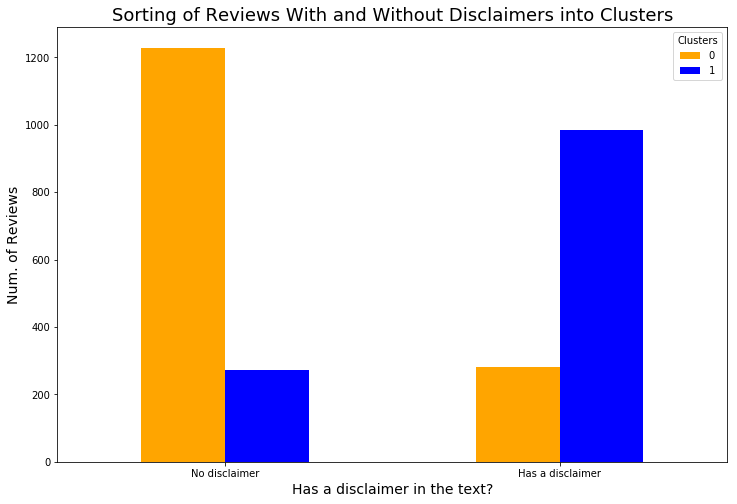

In [59]:
xtab.plot(kind = "bar", stacked = False, colors = ["orange", "blue"], grid = False).get_legend().set_title("Clusters")
plt.xlabel("Has a disclaimer in the text?", fontsize = 14)
plt.ylabel("Num. of Reviews", fontsize = 14)
plt.title("Sorting of Reviews With and Without Disclaimers into Clusters", fontsize = 18)
plt.xticks([False, True], ["No disclaimer", "Has a disclaimer"], rotation = "horizontal")

## Top words

Now let's take a look at some top terms from each cluster. Keep in mind that I did not remove stopwords when tokenizing, because the frequency of usage of stopwords can contain valuable information according to psychology research.

In [ ]:
# Let's look at some top terms
top_terms = 50

order_centroids = km_model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()

top_terms_df = pd.DataFrame()

for i in range(n_k):
    temp_terms = []
    
    for ind in order_centroids[i, :top_terms]:
        temp_terms.append(terms[ind])
    
    top_terms_df["cluster_{}".format(i)] = (pd.Series(temp_terms))

In [28]:
top_terms_df.head(n=50)

,cluster_0,cluster_1
0,the,the
1,and,it
2,it,to
3,to,and
4,this,my
5,for,this
6,is,of
7,my,for
8,great,is
9,of,in


## What's next?

- Using cosine similarity between documents to validate these results
- Validating model results against a small sample of hand-coded reviews